In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install wordcloud matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input, Dense, Embedding, Dot, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,TensorBoard

from wordcloud import WordCloud
%matplotlib inline

#### Reading data

In [4]:
import os

In [5]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [6]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv") , low_memory=True,usecols=["user_id","anime_id","rating"])

In [7]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [8]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


#### Data Processing

In [9]:
n_user = rating_df['user_id'].value_counts()

In [10]:
n_user

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [11]:
rating_df = rating_df[rating_df["user_id"].isin(n_user[n_user>=400].index)].copy()

In [12]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [13]:
len(rating_df)

3246641

In [14]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [15]:
avg_rating

np.float64(4.122732695114736)

In [16]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating))

In [17]:
np.mean(rating_df['rating'])

np.float64(0.4122732695114729)

In [18]:
rating_df.duplicated().sum()

np.int64(0)

In [19]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [20]:
user_ids = rating_df['user_id'].unique().tolist()

In [21]:
user2user_encoding = {x : i for i,x in enumerate(user_ids)}
user2user_decoding = {i : x for i,x in enumerate(user_ids)}

rating_df["user"] = rating_df['user_id'].map(user2user_encoding)

In [22]:
n_user = len(user_ids)

In [23]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [24]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoding = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoding = {i : x for i,x in enumerate(anime_ids)}

rating_df["anime"] = rating_df['anime_id'].map(anime2anime_encoding)

In [25]:
n_anime = len(anime2anime_encoding)

In [26]:
n_anime

17149

In [27]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [28]:
X = rating_df[['user','anime']]
y = rating_df["rating"]

In [29]:
test_size = 1000

In [30]:
train_indices = rating_df.shape[0] - test_size

In [31]:
X_train , X_test , y_train , y_test = X[:train_indices].values , X[train_indices:].values ,y[:train_indices].values , y[train_indices:].values 

In [32]:
len(X_train) , len(X_test)

(3245641, 1000)

In [33]:
X_train_array = [X_train[ : , 0],X_train[ :, 1]]
X_test_array = [X_test[ : , 0],X_test[ : , 1]]

In [34]:
type(X_test_array) , type(X_test_array[0])

(list, numpy.ndarray)

### Model Architecture

In [35]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name= "user_embeddings",input_dim=n_user,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name= "anime_embeddings",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name = "Dot_product" , normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user,anime],outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='Adam',metrics = ['mae','mse'])

    return model

In [36]:
n_anime

17149

In [37]:
model = RecommenderNet()

In [38]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embeddings     │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embeddings    │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embeddings[… │
│                     │                   │            │ anime_embeddings… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ Dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [39]:
start_learning_rate = 0.0001
min_learning_rate = 0.0001
max_learning_rate = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0
exp_decay = 0.8

def lrfn(epoch):

    if epoch<ramup_epoch:
        return(max_learning_rate-start_learning_rate)/ramup_epoch*epoch+start_learning_rate
    
    elif epoch<ramup_epoch+sustain_epoch:
        return max_learning_rate
    
    else:
        return (max_learning_rate-min_learning_rate)*exp_decay **(epoch-ramup_epoch-sustain_epoch) + min_learning_rate

In [40]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_weight = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_weight,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode = 'min',
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor = "val_loss",
                               mode = 'min',
                               restore_best_weights =True)

In [41]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [42]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=20,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.7926 - mae: 0.3807 - mse: 0.1948 - val_loss: 0.7093 - val_mae: 0.3686 - val_mse: 0.1645 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.7608 - mae: 0.3676 - mse: 0.1817 - val_loss: 0.7498 - val_mae: 0.3725 - val_mse: 0.1797 - learning_rate: 9.0000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.7197 - mae: 0.3489 - mse: 0.1645 - val_loss: 0.7135 - val_mae: 0.3501 - val_mse: 0.1633 - learning_rate: 8.0000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.6616 - mae: 0.3192 - mse: 0.1393 - val_loss: 0.6620 - val_mae: 0.3202 - val_mse: 0.1407 - learning_rate: 7.0000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.6170 - mae: 0.2941 - mse: 0.1197 - val_loss: 0.6317 - val_mae: 0.3026 - val_mse: 0.1274 - learning_rate: 6.0000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.5937 - mae: 0.2802 - mse: 0.1095 - val_los

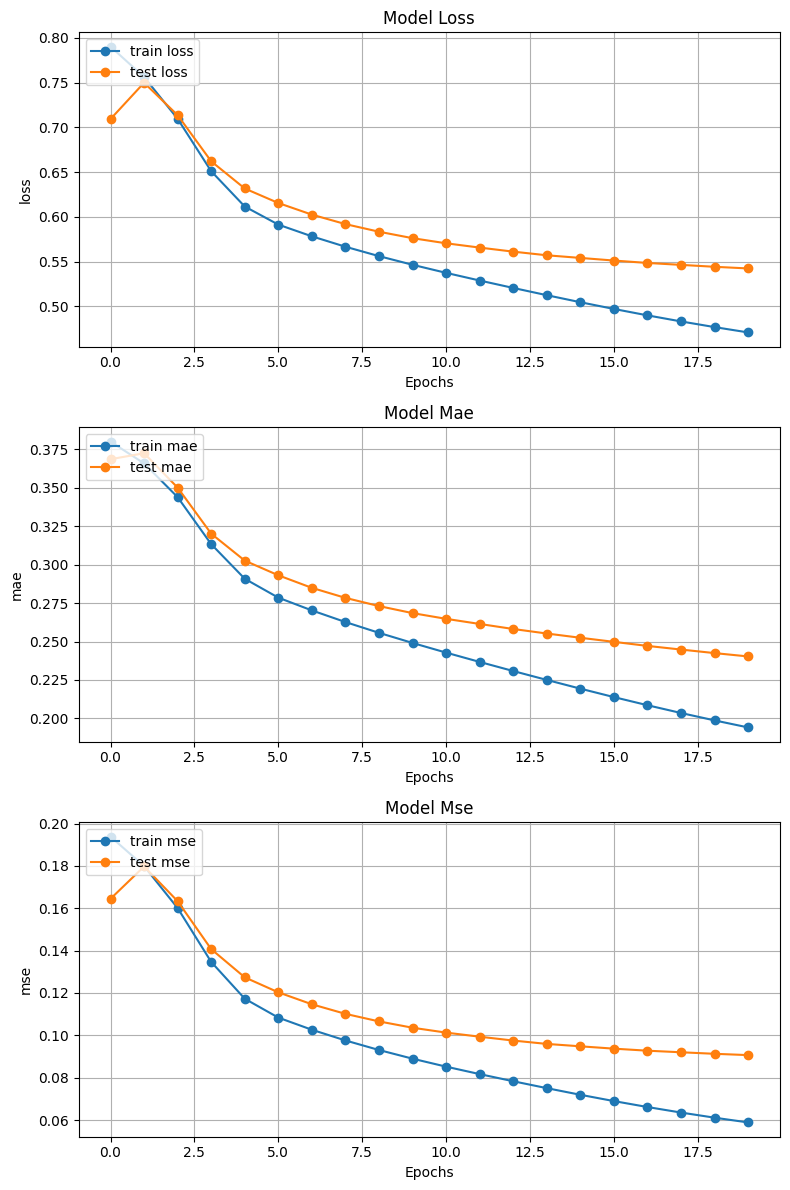

In [43]:
metrics = ["loss","mae","mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric],marker = "o",label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"],marker = "o",label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    ax.legend(loc = "upper left")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [44]:
def extract_weights(name,model):
    weights_layer = model.get_layer(name)
    weights = weights_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights


In [45]:
anime_weights = extract_weights("anime_embeddings",model)

In [46]:
user_weights = extract_weights("user_embeddings",model)

#### Reading Anime.csv

In [47]:
df = pd.read_csv(INPUT_DIR+"/anime.csv" ,low_memory=True)

In [48]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [49]:
df = df.replace("Unknown",np.nan)

In [50]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
        return name
    except:
        print("Error")

In [51]:
df['anime_id'] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:get_anime_name(x))

In [52]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [53]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [54]:
get_anime_name(67)

'Basilisk'

In [55]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

In [56]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [57]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [58]:
df = df [["anime_id","eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [59]:
df.columns

Index(['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type',
       'Premiered', 'Members'],
      dtype='object')

In [60]:
def get_anime_frame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [61]:
get_anime_frame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### Anime_with_synopsis.csv

In [62]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [63]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv" ,usecols=cols)

In [64]:
(synopsis_df.MAL_ID == 3793).sum()

np.int64(0)

In [65]:
def get_synopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return df[df.Name == anime].sypnopsis.values[0]

#### Content Based Recommendation System

In [66]:
pd.set_option("max_colwidth",None)

In [67]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [68]:
def find_similar_animes(name,
                        anime_weights,
                        anime2anime_encoding,
                        anime2anime_decoding,
                        df,
                        synopsis_df,
                        n=10,
                        return_dist = False,
                        neg=False):
    try:
        index = get_anime_frame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoding.get(index)
        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dist = np.argsort(dists)

        n=n+1

        if neg :
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists , closest
        
        similarity_array = []
        for close in closest:

            decoded_id = anime2anime_decoding.get(close)

            print(decoded_id)
            synopsis = get_synopsis(decoded_id,synopsis_df)

            anime_frame = get_anime_frame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.values[0]
            similarity = dists[close]

            similarity_array.append(
                {
                    "anime_id" :decoded_id,
                    "name": anime_name,
                    "genre": genre,
                    "similarity": similarity,
                    "synopsis" : synopsis
                }
            )
        
        frame = pd.DataFrame(similarity_array).sort_values(by ="similarity" ,ascending=False)
        return frame[frame.anime_id!=index].drop(["anime_id"],axis=1)
    except Exception as e: 
        print("Error",e)

In [69]:
find_similar_animes(
    "Doraemon the Movie:Nobita and the Birth of Japan 2016",
    anime_weights,
    anime2anime_encoding,
    anime2anime_decoding,
    df,
    synopsis_df
)

Anime closest to Doraemon the Movie:Nobita and the Birth of Japan 2016
1331
Error index 0 is out of bounds for axis 0 with size 0


In [70]:
anime2anime_decoding.get(3793)

9724

In [72]:
get_synopsis(793,synopsis_df)

"Summer break has arrived, but while his other classmates are out having fun, Kimihiro Watanuki continues to work as compensation for the eccentric Yuuko in her shop. With the spirits and supernatural phenomena that bother him lessening, he pays his dues by cleaning, cooking, and doing whatever else the apparently lazy Yuuko needs. Watanuki, however, gets involved in a new predicament when Yuuko receives a mysterious invitation to a mansion whose owner seeks Yuuko's wish-granting ability. When he, Yuuko, and his classmate Shizuka Doumeki make their way to the peculiar residence, they meet others who were summoned by the same strange invitation. All of them are collectors of various unique items, drawn there by the chance to expand their collections. But as the collectors begin to disappear one by one, Watanuki and his companions must solve the mystery and put the case to rest, or find themselves in risk of danger."

In [73]:
get_anime_frame("Doraemon the Movie:Nobita and the Birth of Japan 2016",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10860,31201,Doraemon the Movie:Nobita and the Birth of Japan 2016,7.25,"Adventure, Comedy, Fantasy, Kids, Shounen",1,Movie,NaN,2565


In [74]:
df.sample(10)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
16734,41651,Mushiba no Kodomo no Tanjoubi,NaN,"Kids, Music",1,Music,NaN,67
14577,37937,Wan Jie Xian Zong,7.37,"Action, Adventure, Demons, Fantasy, Historical, Martial Arts, Romance",40,ONA,NaN,2246
15881,39938,Inu-Ou,NaN,"Fantasy, Historical, Music",1,Movie,NaN,2119
3180,3628,Rxxx:Prescription for Pain,5.79,Hentai,2,OVA,NaN,1618
14978,38544,The Price of Smiles,6.06,"Military, Slice of Life, Drama, Fantasy, Mecha",12,TV,Winter 2019,30695
2229,2434,Slutty-Princess Diaries,5.94,Hentai,3,OVA,NaN,2195
5573,8925,Kobe to Watashi,4.57,"Comedy, Slice of Life",1,ONA,NaN,1179
421,449,InuYasha the Movie 4:Fire on the Mystic Island,7.54,"Action, Adventure, Comedy, Historical, Demons, Supernatural, Drama, Magic, Romance, Fantasy, Shounen",1,Movie,NaN,75376
1625,1786,Sprite:Between Two Worlds,5.79,"Comedy, Ecchi, Romance, School",2,OVA,NaN,1789
5881,9741,Nana to Kaoru,5.6,"Comedy, Ecchi, Romance, Seinen",1,OVA,NaN,20691


In [75]:
anime2anime_decoding.get(3793)

9724

In [76]:
anime2anime_encoding.get(9724)

3793

In [77]:
anime2anime_encoding

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [78]:
anime2anime_decoding

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 

#### USER BASED RECOMMENDATION

In [79]:
def find_similar_users(item_input,
                       user_weights,
                       user2user_encoding,
                       user2user_decoding,
                       n=10,
                       return_dist = False,
                       neg = False):
    try:
        index = item_input
        encoded_index = user2user_encoding.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])

        sorted_dist = np.argsort(dists)

        n=n+1

        if neg :
            closest = sorted_dist[:n]
        else:
            closest = sorted_dist[-n:]
        
        if return_dist:
            return dists,closest
        
        similarity_array = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoding.get(close)
                similarity_array.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(similarity_array).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users!=item_input]
        return similar_users
    except Exception as e:
        print("Error",e)

In [80]:
find_similar_users(int(11880),user_weights,user2user_encoding,user2user_decoding)

,similar_users,similarity
9,2902,0.519196
8,1723,0.443638
7,8074,0.414902
6,15310,0.403261
5,7135,0.402860
4,2997,0.402304
3,8258,0.400254
2,1107,0.391547
1,8331,0.390974
0,11654,0.390184


In [81]:
def show_word_cloud(all_genres):
    genre_cloud = WordCloud(width=700,
                            height=400,
                            background_color='white',
                            colormap="gnuplot").generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8))
    plt.imshow(genre_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [82]:
from collections import defaultdict

In [83]:
def get_fav_genre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []

    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()] +=1
    if plot:
        show_word_cloud(all_genres)
    return genres_list 

In [84]:
x = get_anime_frame(1,df)

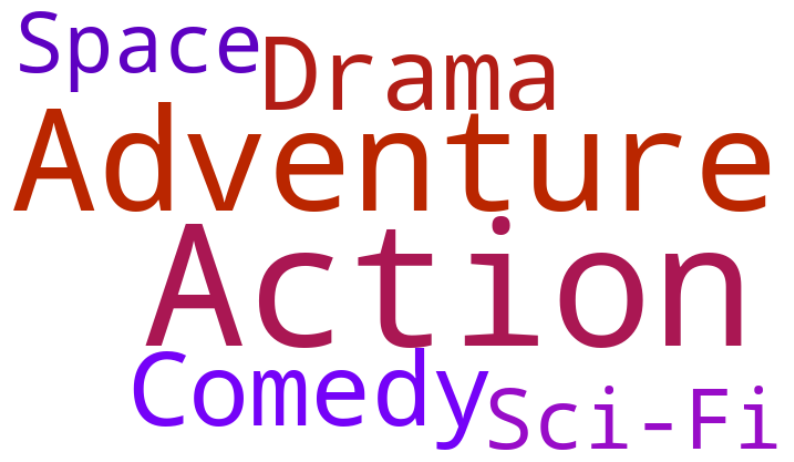

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [85]:
get_fav_genre(x,plot=True)

In [86]:
def get_user_preferences(user_id,rating_df,df,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating,75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user =(
        animes_watched_by_user.sort_values(by='rating',ascending=False).anime_id.values
    ) 

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]

    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        get_fav_genre(anime_df_rows,True)

    return anime_df_rows

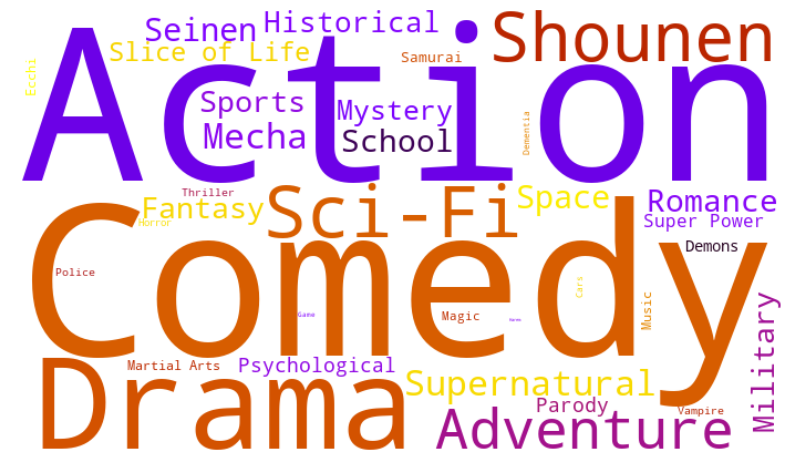

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [87]:
get_user_preferences(11880,rating_df,df,True)

In [103]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = get_anime_frame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = get_synopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [104]:
similar_users = find_similar_users(int(11880),user_weights,user2user_encoding,user2user_decoding)

In [105]:
user_pref = get_user_preferences(11880,rating_df,df,False)

In [106]:
get_user_recommendations(similar_users,
                         user_pref,
                         df,
                         synopsis_df,
                         rating_df)

,n,anime_name,Genres,Synopsis
0,9,Clannad ~After Story~,"Slice of Life, Comedy, Supernatural, Drama, Romance","Clannad: After Story , the sequel to the critically acclaimed slice-of-life series Clannad , begins after Tomoya Okazaki and Nagisa Furukawa graduate from high school. Together, they experience the emotional rollercoaster of growing up. Unable to decide on a course for his future, Tomoya learns the value of a strong work ethic and discovers the strength of Nagisa's support. Through the couple's dedication and unity of purpose, they push forward to confront their personal problems, deepen their old relationships, and create new bonds. Time also moves on in the Illusionary World. As the plains grow cold with the approach of winter, the Illusionary Girl and the Garbage Doll are presented with a difficult situation that reveals the World's true purpose. Based on the visual novel by Key and produced by Kyoto Animation, Clannad: After Story is an impactful drama highlighting the importance of family and the struggles of adulthood."
1,8,Kanon,"Slice of Life, Supernatural, Drama, Romance","s a young child, Aizawa Yuuichi had often visited his cousin in the city; however, something drastic happened to keep him away for seven long years. Now, Yuuichi returns, his memories of those days are simply gone. Settling into the wintry town, Yuuichi comes across several young girls, all of whom are connected to his past. As he befriends them and continues to interact with them, the long forgotten memories from his childhood begin to resurface..."
2,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
3,8,Code Geass:Lelouch of the Rebellion,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
4,8,Fate/Zero Season 2,"Action, Supernatural, Magic, Fantasy","s the Fourth Holy Grail War rages on with no clear victor in sight, the remaining Servants and their Masters are called upon by Church supervisor Risei Kotomine, in order to band together and confront an impending threat that could unravel the Gra